# Lagrangian particle tracking with ACCESS-OM2-01. 

Lagrangian particle tracking is widely used in a range of physical and biological oceanography applications. This [review paper](https://www.sciencedirect.com/science/article/pii/S1463500317301853) on Lagrangian fundamentals covers many of the basics and provides an overview of the different particle tracking software programs available to the oceanography community. In this notebook we'll use [Parcels](https://github.com/OceanParcels/parcels) which has the advantage of a large user community and an active development team. The [Parcels website](https://oceanparcels.org) is well documented and has some great general tutorials to get you started. In this tutorial, we'll focus on how to get a simple particle tracking experiment running with output from the ACCESS-OM2-01 model. 

**Requirements:** `conda/analysis3-23.07` (or later) 

Firstly, load in the required modules. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cosima_cookbook as cc

from glob import glob
from datetime import timedelta
from dask.distributed import Client
from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4, AdvectionRK4_3D, __version__ 

In [2]:
print('parcels', __version__)

parcels 3.0.0


It's often a good idea to start a cluster with multiple cores for you to work with. 

In [3]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44369,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:42305,Total threads: 3
Dashboard: /proxy/45567/status,Memory: 11.50 GiB
Nanny: tcp://127.0.0.1:40265,


**Define the velocity fields and any other model data we want Parcels to read**

We're now going to run some simple offline Lagrangian particle tracking experiments. This means we need to read in some velocity fields that have been output from an ocean model and feed these to Parcels. Generally speaking, you want to run Lagrangian particle tracking experiments with the highest temporal resolution available. We have several periods of daily output from ACCESS-OM2-01 available on Gadi. These are listed below.

- 21 years of daily `u,v,wt` from the **RYF** simulation corresponding to model years 50-71. This is stored in folders `output146-output279` here: `/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/`
- 31 years of daily `u,v,wt` from cycle 1 of the **IAF** simulation from 1987 to 2018. This is stored in folders `output116 - output243` here: `/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf`

We'll use the first year of the daily RYF data for this experiment. We'll also start with a simple 2D advection example, and then run a 3D particle advection experiment with temperature and salinity. 

In [4]:
dir = ! echo /scratch/$PROJECT/$USER/particle_tracking

print(f"WARNING: Output is being saved in this directory: {dir[0]} \nChange to any directory you would like.")
output_directory = dir[0]
output_directory

Change to any directory you would like.


'/scratch/tm70/as2285/particle_tracking'

##  2D Advection

In [5]:
%%time
# First, we need to define ACCESS-OM2-01 (MOM5 ocean) NetCDF files.
data_path = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/'

# At a minimum, Parcels needs U and V files (2D advection). 
ufiles = sorted(glob(data_path+'output19*/ocean/ocean_daily_3d_u_*.nc'))
vfiles = sorted(glob(data_path+'output19*/ocean/ocean_daily_3d_v_*.nc'))

# We then need to read in a file that contains the grid coordinates which are saved in the `ocean.nc` file.
# However our daily velocity data is only saved up to -32.59S and does not cover the whole globe. 
# We need to select out only the Southern Ocean region and resave the grid coordinates to file. 
orig_mesh_mask = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output196/ocean/ocean.nc'
ds = xr.open_dataset(orig_mesh_mask).sel(yu_ocean=slice(None, -32.52)).sel(yt_ocean=slice(None, -32.55))
variables = ['v', 'wt']
ds = ds[variables]

mesh_mask = output_directory+'ocean.nc'
ds.to_netcdf(mesh_mask)

CPU times: user 2min 29s, sys: 11.7 s, total: 2min 41s
Wall time: 2min 40s


In [6]:
# We now define a dictionary that tells Parcels where the U,V data is, and where to 
# find the coordinates. 
filenames = {
    'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': ufiles},
    'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': vfiles},
}

# Now define a dictionary that specifies the `U, V` variable names as given in the netcdf files  
variables = { 'U': 'u', 'V': 'v'}

# Define a dictionary to specify the U,V dimentions. 
# See the description under the 3D advection section for why we specify sw_ocean as the depth here. 
# For further reading, also see this tutorial on the Ocean Parcels website: https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_indexing.ipynb
dimensions = {
    'U': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'},
    'V': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'}
}

indices = {'sw_ocean': range(0, 3)}

# Define the chunksizes for each variable. This will help Parcels read in the FieldSet. 
cs = {
    "U": {"lon": ("xu_ocean", 400), "lat": ("yu_ocean", 300), "depth": ("st_ocean", 7), "time": ("time", 1)}, 
    "V": {"lon": ("xu_ocean", 400), "lat": ("yu_ocean", 300), "depth": ("st_ocean", 7), "time": ("time", 1)},
}

# Finally, we load the fieldset using the Parcels `FieldSet.from_mom5` function. 
fieldset = FieldSet.from_mom5(filenames, variables, dimensions, indices,
                              mesh = 'spherical', 
                              chunksize = cs, 
                              tracer_interp_method = 'bgrid_tracer')

We need to tell Parcels that this fieldset is periodic in the zonal (east-west) direction. This is because, if the particle is close to the edge of the fieldset (but still in it), the advection scheme will need to interpolate velocities that may lay outside the fieldset domain. With the halo, we make sure the advection kernel can access these values.

In [7]:
fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

We now need a custom kernel that can move the particle from one side of the domain to the other.

In [8]:
def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

We'll also add a recovery kernel to delete particles if they encounter the `ErrorOutOfBounds` signal from Parcels. 

In [9]:
def checkOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

Now we can create the **Particle Set**. This contains the particle starting locations and type of particle. We'll read in the `ht` field from the model and initialise particles in a small section across the ACC.

In [10]:
session = cc.database.create_session()
experiment = '01deg_jra55v13_ryf9091'
ht = cc.querying.getvar(experiment, 'ht', session, n=1).load()

In [11]:
x1, x2 = -100.5, -100
y1, y2 = -60, -65

lons = ht.where((ht.yt_ocean<y1)&(ht.yt_ocean>y2)&(ht.xt_ocean<x2)&(ht.xt_ocean>x1), 
                drop=True).geolon_t.values.ravel()
lats = ht.where((ht.yt_ocean<y1)&(ht.yt_ocean>y2)&(ht.xt_ocean<x2)&(ht.xt_ocean>x1), 
                drop=True).geolat_t.values.ravel()

depths = np.full(len(lats), 1.)

pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=lons,            # a vector of release longitudes 
                             lat=lats,            # a vector of release latitudes
                             depth=depths,        # a vector of release depths 
                             time=0.)             # set time to start start time of daily velocity fields
pset

P[0](lon=-100.449997, lat=-64.973167, depth=1.000000, time=0.000000)
P[1](lon=-100.349998, lat=-64.973167, depth=1.000000, time=0.000000)
P[2](lon=-100.250000, lat=-64.973167, depth=1.000000, time=0.000000)
P[3](lon=-100.150002, lat=-64.973167, depth=1.000000, time=0.000000)
P[4](lon=-100.050003, lat=-64.973167, depth=1.000000, time=0.000000)
P[5](lon=-100.449997, lat=-64.930832, depth=1.000000, time=0.000000)
P[6](lon=-100.349998, lat=-64.930832, depth=1.000000, time=0.000000)
P[7](lon=-100.250000, lat=-64.930832, depth=1.000000, time=0.000000)
P[8](lon=-100.150002, lat=-64.930832, depth=1.000000, time=0.000000)
P[9](lon=-100.050003, lat=-64.930832, depth=1.000000, time=0.000000)
P[10](lon=-100.449997, lat=-64.888428, depth=1.000000, time=0.000000)
P[11](lon=-100.349998, lat=-64.888428, depth=1.000000, time=0.000000)
P[12](lon=-100.250000, lat=-64.888428, depth=1.000000, time=0.000000)
P[13](lon=-100.150002, lat=-64.888428, depth=1.000000, time=0.000000)
P[14](lon=-100.050003, lat=-64

Plot these particles. 

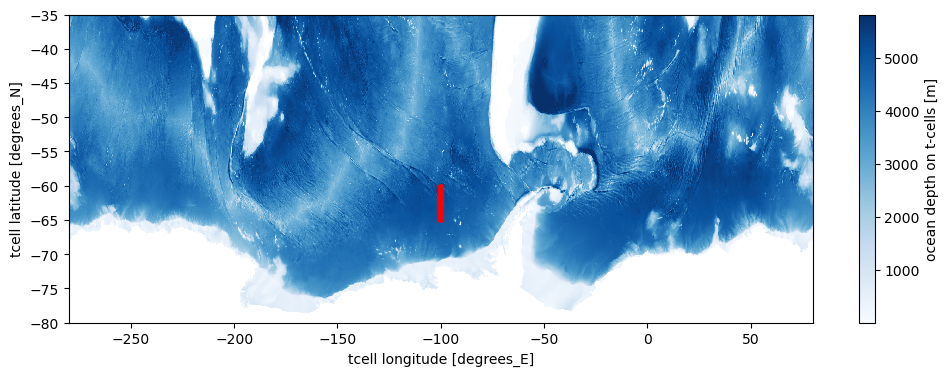

In [12]:
fig = plt.figure(figsize=(12, 4))

ht.plot(cmap='Blues')
plt.scatter(lons, lats, s=5, c='r')
plt.ylim([-80, -35]);

We can now advect these particles with Parcels. We'll do this using 4th order Runge-Kutta in 2D. In this example, we'll integrate the particle positions for only 50 days to keep it simple. This may take a few minutes depending on the resources you're using. Feel free to change the total length of the run as you like. 

**Note**: This cell might take 3-4 minutes.

In [13]:
# Set your output location: 
output_filename = 'TestParticles_2D.zarr'

# the file name and the time step of the outputs 
# (particle locations will be saved every 5 days in this example)
output_file = pset.ParticleFile(
    name=output_directory + output_filename, 
    outputdt=timedelta(days=2)
) 

pset.execute(
    [
        AdvectionRK4, # the 2D advection kernel (which defines how particles move) at least one of these needs the pset.Kernel() surrounding it. 
        periodicBC ,
        checkOutOfBounds 
    ],
    runtime=timedelta(days=50),   # the total length of the run
    dt=timedelta(hours=2),        # the integration timestep of the kernels
    output_file=output_file,      # the output file
)      

INFO: Output files are stored in /scratch/tm70/as2285/particle_trackingTestParticles_2D.zarr.
100%|██████████| 4320000.0/4320000.0 [01:14<00:00, 58373.79it/s]


Open output file and plot the first 100 of these trajectories. 

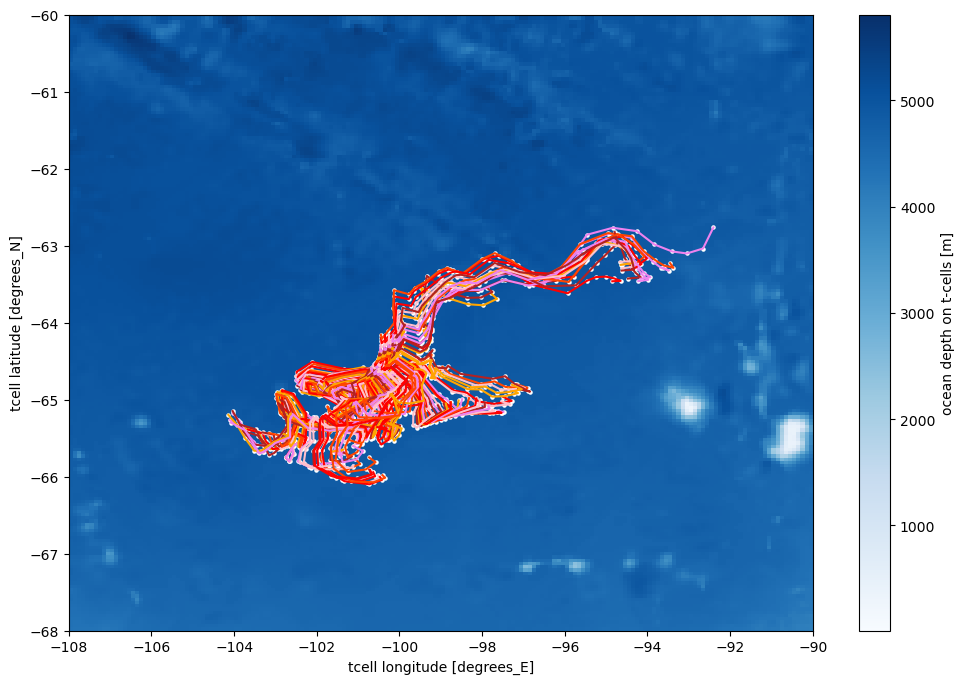

In [14]:
ds = xr.open_zarr(output_directory + output_filename)

fig = plt.figure(figsize=(12, 8))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "pink", "violet", "firebrick", "orange", "orangered"])

ht.plot(cmap='Blues')

plt.plot(ds.lon[:100, :].T, ds.lat[:100, :].T)
plt.scatter(ds.lon[:100, :], ds.lat[:100, :], s=5, c='w')

plt.ylim([-68, -60])
plt.xlim([-108, -90]);

## 3D Advection with temperature and salinity

Now we'll run an example in 3D and also sample and save temperature and salinity fields. 

In [15]:
# First, we need to define ACCESS-OM2-01 (MOM5 ocean) NetCDF files.
data_path = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/'

# At a minimum, Parcels needs U and V files (2D advection), and W for 3D advection. 
ufiles = sorted(glob(data_path+'output19*/ocean/ocean_daily_3d_u_*.nc')) 
vfiles = sorted(glob(data_path+'output19*/ocean/ocean_daily_3d_v_*.nc')) 
wfiles = sorted(glob(data_path+'output19*/ocean/ocean_daily_3d_wt_*.nc'))

# Optional
# You can also feed Parcels temperature, salinity, and 2D fields such as MLD. 
# These should be at the same temporal resolution as the U, V and W fields. 
tfiles = sorted(glob(data_path+'output19*/ocean/ocean_daily_3d_temp_*.nc')) 
sfiles = sorted(glob(data_path+'output19*/ocean/ocean_daily_3d_salt_*.nc')) 

# Read in the grid coordinates
# NOTE: If you haven't already created this file in the 2D advection example, then you need to 
#       do so before moving on.
mesh_mask = output_directory+'ocean.nc'

We now need to set up the Parcels `FieldSet`. For 3D advection we also need a vertical velocity field (`W`), and in this example we'll add temperature and salinity as well.

**Note:** Initialising the `FieldSet` can take some time depending on the domain and number of files you're feeding to Parcels. In this example, it should be quick. 

In [16]:
%%time
# We now define a dictionary that tells Parcels where the U,V data is, and where to 
# find the coordinates. 
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': wfiles},
             'T': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': tfiles},
             'S': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': mesh_mask, 'data': sfiles},
             }

# Now define a dictionary that specifies the (`U,V,W` etc) variable names as given in the netcdf files  
variables = {'U': 'u',
             'V': 'v',
             'W': 'wt',
             'T': 'temp',
             'S': 'salt',
             }

# Define a dictionary to specify the U,V, W etc dimentions. 
# All variables must have the same lat/lon/depth dimensions (even though the ACCESS-OM2-01 data doesn't). 
# When we developed the from_mom5() method, Parcels expected the dimensions on the 
# upper-right verticies of the grid cells. Hoewever, in ACCESS-OM2-01, the vertical 
# velocity is defined on the bottom face of the grid cell, not the top. Therefore
# the from_mom5() method adds a layer to the top of the vertical velocity field such that wt = 0 @ 0m, 
# so that the vertical velocities are correctly defined at the top surface of the grid cells. 
dimensions = {'U': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'},
              'V': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'},
              'W': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'},
              'T': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'},
              'S': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'},
              }

# Define the chunksizes for each variable. This will help Parcels read in the FieldSet. 
cs = {"U": {"lon": ("xu_ocean", 400), "lat": ("yu_ocean", 300), "depth": ("st_ocean", 7), "time": ("time", 1)}, 
      "V": {"lon": ("xu_ocean", 400), "lat": ("yu_ocean", 300), "depth": ("st_ocean", 7), "time": ("time", 1)},
      "W": {"lon": ("xt_ocean", 400), "lat": ("yt_ocean", 300), "depth": ("sw_ocean", 7), "time": ("time", 1)},
      "T": {"lon": ("xt_ocean", 400), "lat": ("yt_ocean", 300), "depth": ("st_ocean", 7), "time": ("time", 1)},
      "S": {"lon": ("xt_ocean", 400), "lat": ("yt_ocean", 300), "depth": ("st_ocean", 7), "time": ("time", 1)},
       }

# Finally, we load the fieldset using the Parcels `FieldSet.from_mom5` function. 
fieldset = FieldSet.from_mom5(filenames, variables, dimensions, #indices,
                              mesh = 'spherical', 
                              chunksize=cs, 
                              tracer_interp_method = 'bgrid_tracer')

# Finally, we load the fieldset using the Parcels `FieldSet.from_mom5` function. This may take some time.
# This was adapted from the `from_b_grid_dataset` method to work with ACCESS-OM2-01. 
# Note that W is normally directed upward in MOM5 (the ocean component of ACCESS-OM2-01), 
# but Parcels requires W to be aligned with the positive z-direction (downward in MOM5). As such, 
# the W fields are multiplied by -1 in this method. 
fieldset = FieldSet.from_mom5(filenames, variables, dimensions,
                              mesh = 'spherical', 
                              chunksize = cs, 
                              tracer_interp_method = 'bgrid_tracer')

CPU times: user 2.21 s, sys: 82.8 ms, total: 2.29 s
Wall time: 2.28 s


As for the 2D advection case, we need to tell Parcels that this fieldset is periodic in the zonal (east-west) direction. This is because, if the particle is close to the edge of the fieldset (but still in it), the advection scheme will need to interpolate velocities that may lay outside the fieldset domain. With the halo, we make sure the advection kernel can access these values.

In [17]:
fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

We now need to define a particle class that tells Parcels each particle has a temperature and salinity value associated with it. We also need to define a kernel to tell Parcels to sample the temperature and salinity fields at each integration timestep. 

In [18]:
# Parcels will automatically save the latitude, longitude, and depth to file at a timestep that 
# you specify (see cells below). This kernel tells Parcels to also save the temperature and salinity fields
# to file, along with the location data. 
class SampleParticle(JITParticle):
    thermo = Variable('thermo', dtype=np.float32, initial = 0.)
    psal = Variable('psal', dtype=np.float32, initial = 0.)

# Kernel to sample temperature and salinity (if you have fed them into your FieldSet above).
def SampleFields(particle, fieldset, time):
    particle.thermo = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.psal =   fieldset.S[time, particle.depth, particle.lat, particle.lon]

Now we can create the **Particle Set**. Well use the same particle set as in the 2D example but this time we'll initialise particles at 10m depth. This time you can see that `thermo` and `psal` have been added to the Particle Set. 

In [19]:
session = cc.database.create_session()
experiment = '01deg_jra55v13_ryf9091'
ht = cc.querying.getvar(experiment, 'ht', session, n=1).load()

x1, x2 = -100.5, -100
y1, y2 = -60, -65

lons = ht.where((ht.yt_ocean<y1)&(ht.yt_ocean>y2)&(ht.xt_ocean<x2)&(ht.xt_ocean>x1), 
                drop=True).geolon_t.values.ravel()

lats = ht.where((ht.yt_ocean<y1)&(ht.yt_ocean>y2)&(ht.xt_ocean<x2)&(ht.xt_ocean>x1), 
                drop=True).geolat_t.values.ravel()

depths = np.full(len(lats), 10.)

pset = ParticleSet.from_list(fieldset=fieldset,      # the fields on which the particles are advected
                             pclass=SampleParticle,  # the type of particles we specified above with temp and salt added
                             lon=lons,               # a vector of release longitudes 
                             lat=lats,               # a vector of release latitudes
                             depth=depths,           # a vector of release depths 
                             time=0.)                # set time to start start time of daily velocity fields
pset

P[540](lon=-100.449997, lat=-64.973167, depth=10.000000, thermo=0.000000, psal=0.000000, time=0.000000)
P[541](lon=-100.349998, lat=-64.973167, depth=10.000000, thermo=0.000000, psal=0.000000, time=0.000000)
P[542](lon=-100.250000, lat=-64.973167, depth=10.000000, thermo=0.000000, psal=0.000000, time=0.000000)
P[543](lon=-100.150002, lat=-64.973167, depth=10.000000, thermo=0.000000, psal=0.000000, time=0.000000)
P[544](lon=-100.050003, lat=-64.973167, depth=10.000000, thermo=0.000000, psal=0.000000, time=0.000000)
P[545](lon=-100.449997, lat=-64.930832, depth=10.000000, thermo=0.000000, psal=0.000000, time=0.000000)
P[546](lon=-100.349998, lat=-64.930832, depth=10.000000, thermo=0.000000, psal=0.000000, time=0.000000)
P[547](lon=-100.250000, lat=-64.930832, depth=10.000000, thermo=0.000000, psal=0.000000, time=0.000000)
P[548](lon=-100.150002, lat=-64.930832, depth=10.000000, thermo=0.000000, psal=0.000000, time=0.000000)
P[549](lon=-100.050003, lat=-64.930832, depth=10.000000, thermo=

For the 3D advection we will integrate particles forward-in-time for 20 days to keep this example simple, but feel free to integrate longer! If you want really long integrations you should consider [submitting the analysis as a job on Gadi](https://cosima-recipes.readthedocs.io/en/latest/tutorials/Submitting_analysis_jobs_to_gadi.html#gallery-tutorials-submitting-analysis-jobs-to-gadi-ipynb) or to some other HPC system of your liking.

**Note 1**: Generally you want to use a small integration timestep (`dt`). This is because, the larger the `dt`, the further particles will move in a single timestep and the more likely you are to get particles crossing ocean-land boundaries and 'beaching'. For example, in some Lagrangian applications it is common to use `dt` <= 15 minutes. However the choice of `dt` has to be balanced against the computational resources and the available simulation time. In this example, we'll use a `dt` of 2 hours to speed up the integration. If you want to integrate particles backwards-in-time, simple feed Parcels a negative `dt` value. 

**Note 2**: This 3D example may take some time (~5-10 minutes) depending on the resources you're using.

In [20]:
# Set your output location: 
output_filename = 'TestParticles_3D.zarr'

# the file name and the time step of the outputs 
# (particle locations will be saved every 5 days in this example)
output_file = pset.ParticleFile(name=output_directory + output_filename, 
                                outputdt=timedelta(days=2)) 

pset.execute(
    [
        AdvectionRK4_3D, # the 3D advection kernel (which defines how particles move)
        periodicBC,
        SampleFields,
        checkOutOfBounds
    ],
     runtime=timedelta(days=20),   # the total length of the run
     dt=timedelta(hours=2),        # the integration timestep of the kernel
     output_file=output_file,      # the output file
)      


INFO: Output files are stored in /scratch/tm70/as2285/particle_trackingTestParticles_3D.zarr.
100%|██████████| 1728000.0/1728000.0 [01:16<00:00, 22515.87it/s]


Open output file and scatter plot the first 100 of these trajectories, coloured by depth. 

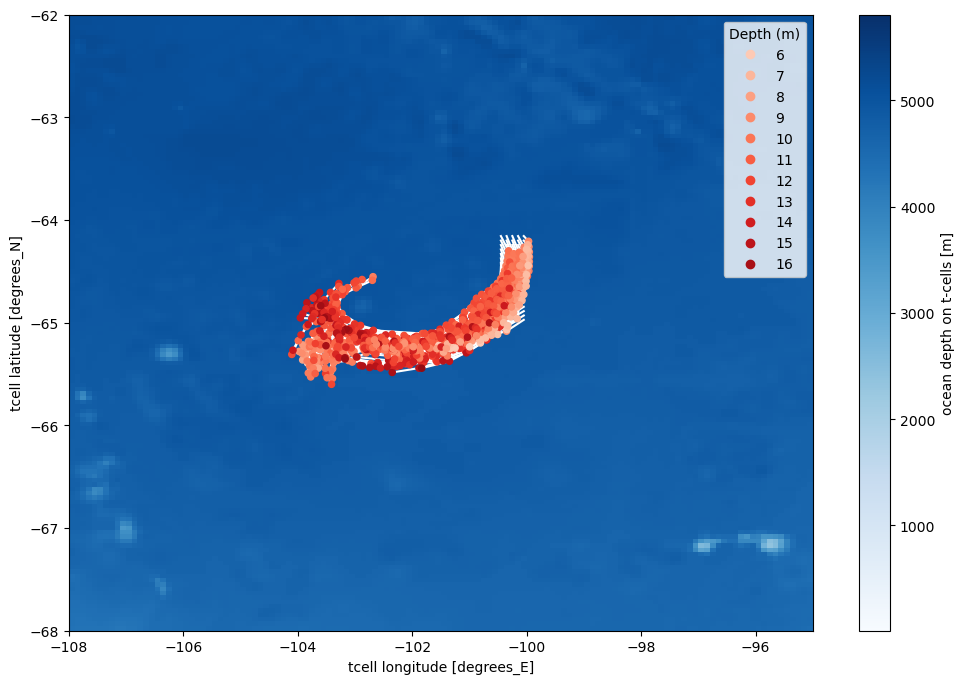

In [21]:
ds = xr.open_zarr(output_directory + output_filename)

fig = plt.figure(figsize=(12, 8))

ht.plot(cmap='Blues')

plt.plot(ds.lon[:100, :].T, ds.lat[:100, :].T, c='w', zorder=2)

cb = plt.scatter(ds.lon[:100, 1:], ds.lat[:100, 1:], c=ds.z[:100, 1:],
                 s=20, vmin=3, vmax=18, cmap='Reds', zorder=3)

plt.legend(*cb.legend_elements(num=10), loc="upper right", title="Depth (m)")

plt.ylim([-68, -62])
plt.xlim([-108, -95]);

For reference, this is how the output file is organised. 

In [22]:
ds

<xarray.Dataset>
Dimensions:     (trajectory: 540, obs: 10)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9
  * trajectory  (trajectory) int64 540 541 542 543 544 ... 1076 1077 1078 1079
Data variables:
    lat         (trajectory, obs) float32 dask.array<chunksize=(540, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(540, 1), meta=np.ndarray>
    psal        (trajectory, obs) float32 dask.array<chunksize=(540, 1), meta=np.ndarray>
    thermo      (trajectory, obs) float32 dask.array<chunksize=(540, 1), meta=np.ndarray>
    time        (trajectory, obs) object dask.array<chunksize=(540, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(540, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3DperiodicBCSampleFiel...
    parcels_mesh:           spherical
    parcels_version:        3.0.0

In [23]:
client.close()